In [110]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [138]:
import cv2
import numpy as np

def circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return 4 * np.pi * (area / (perimeter * perimeter))

def process_mask(gray):
    _, binary = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
    close = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=4)
    open = cv2.morphologyEx(close, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8), iterations=4)

    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(close, 4, cv2.CV_32S)
    density_threshold = 0.4

    # Initialize an empty mask
    component_mask = np.zeros(gray.shape, dtype=np.uint8)

    # Accumulate components that meet the density and circularity conditions
    for i, stat in enumerate(stats[1:], start=1):
        x, y, w, h, area = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT], stat[cv2.CC_STAT_AREA]
        density = area / (w * h)
        if y < 500 or y > 2000:
            continue

        # Extract the component as a separate mask
        single_component_mask = np.zeros_like(binary)
        single_component_mask[labels_im == i] = 255

        # Find contours and calculate circularity
        contours, _ = cv2.findContours(single_component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            circ_value = circularity(max(contours, key=cv2.contourArea))

            # Check for area, density, and non-circularity
            if area > 2000 and density < density_threshold and circ_value < 0.3:
                component_mask[labels_im == i] = 255

    return component_mask



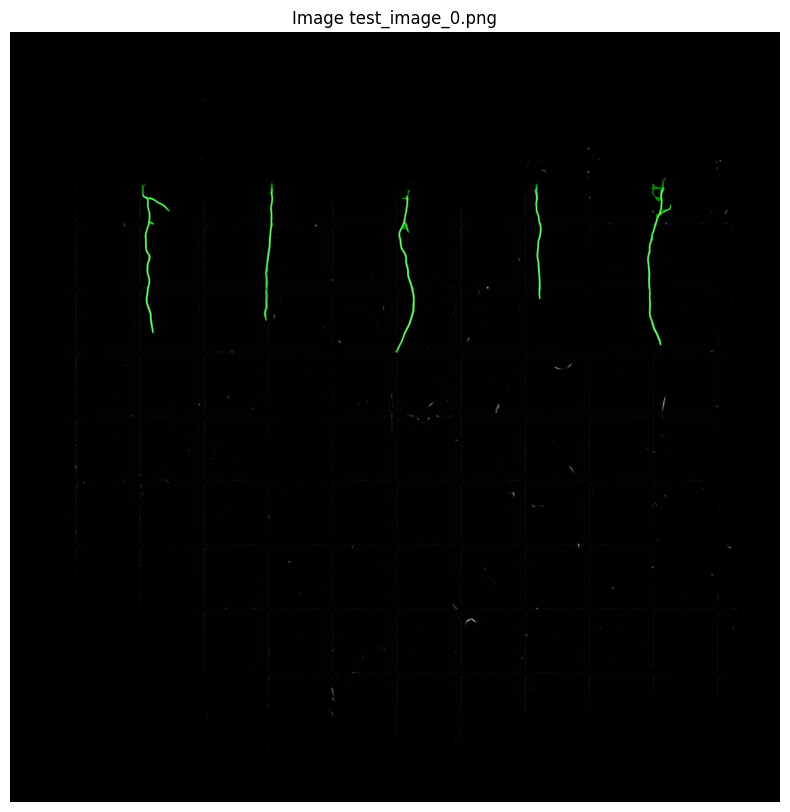

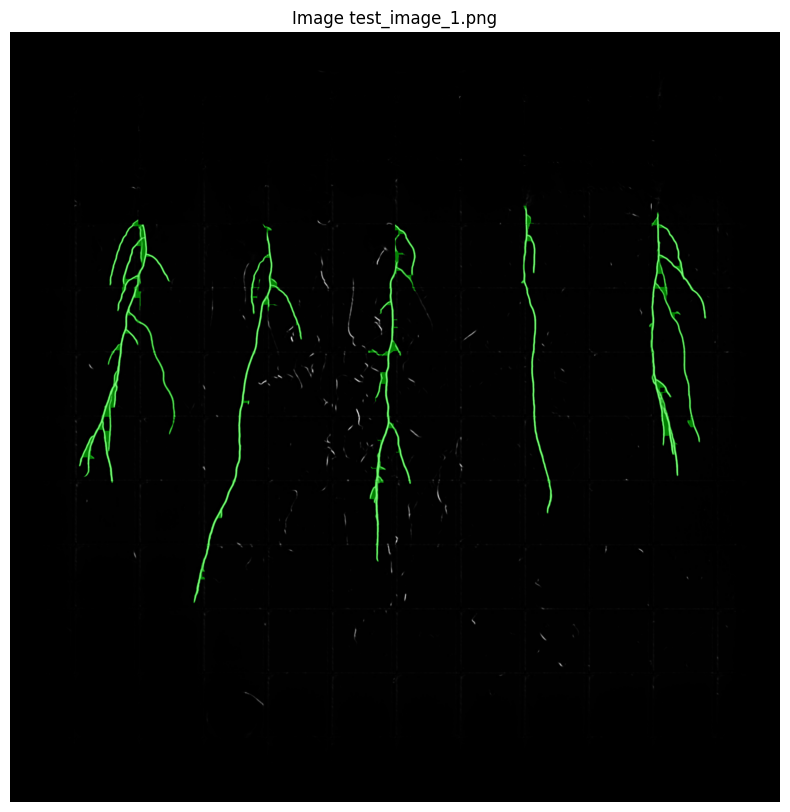

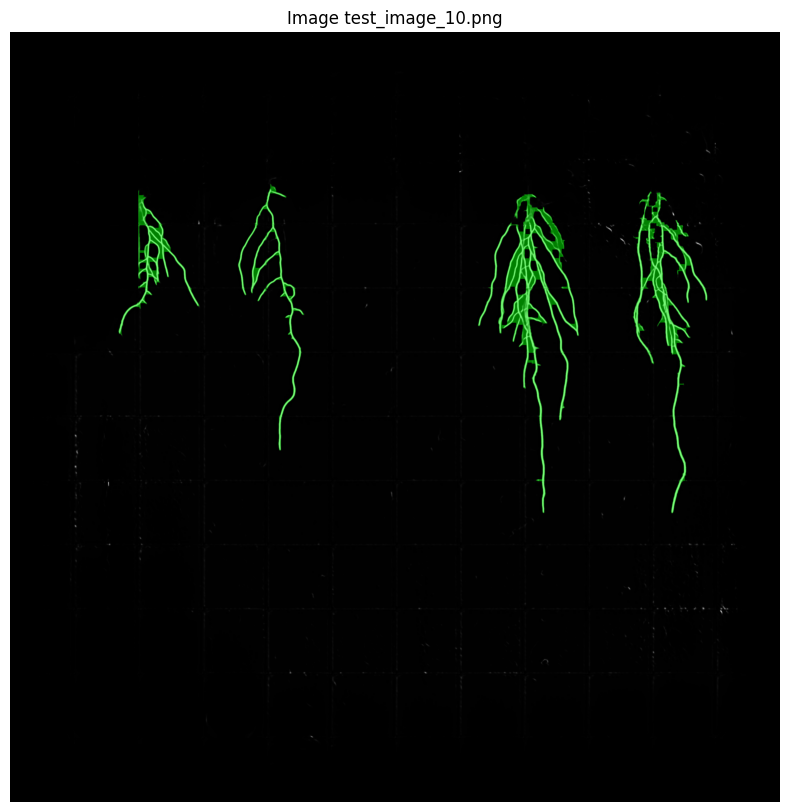

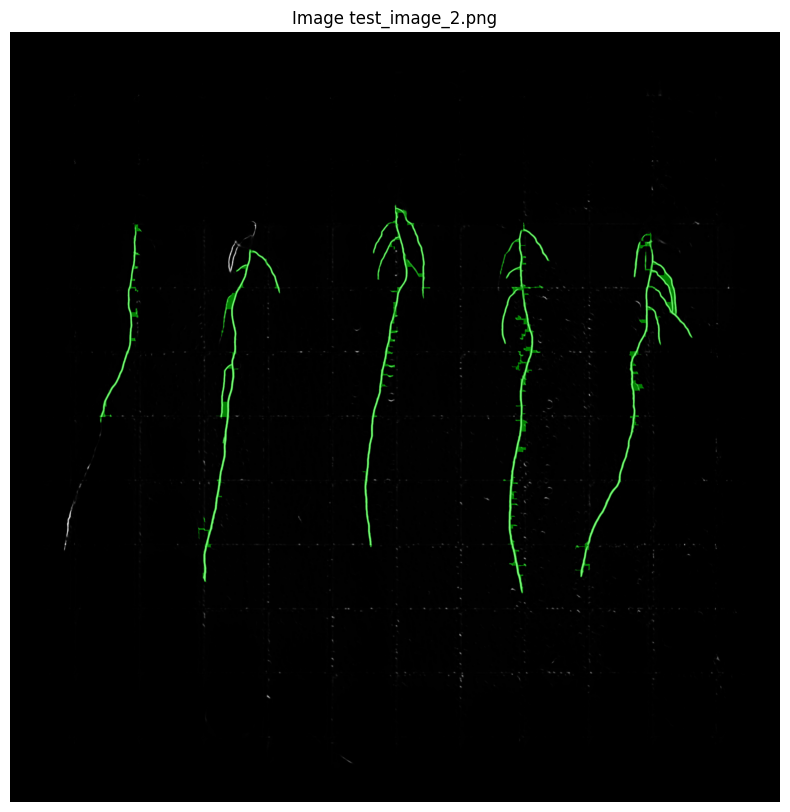

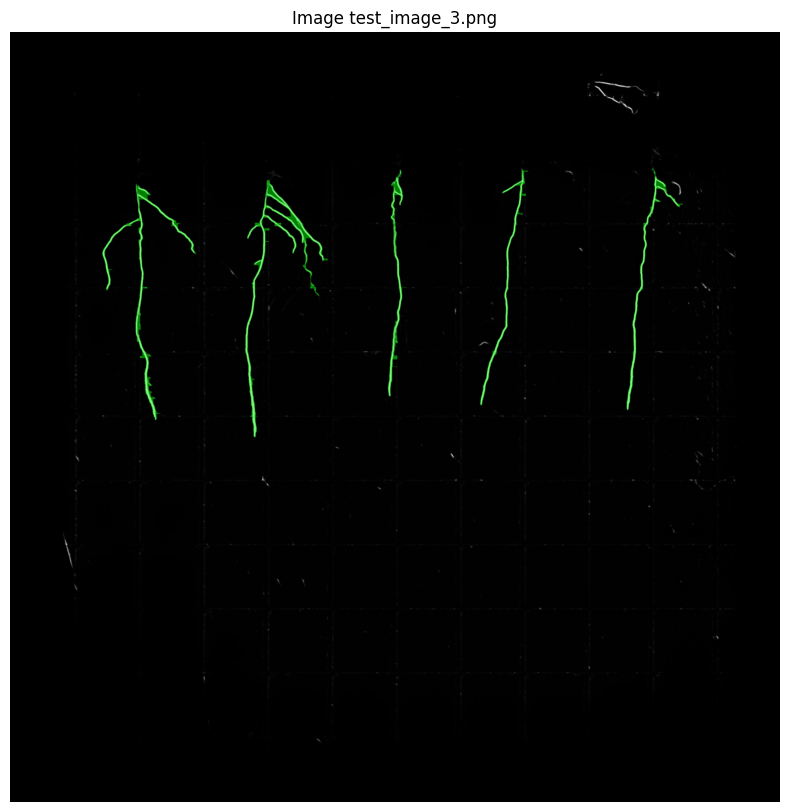

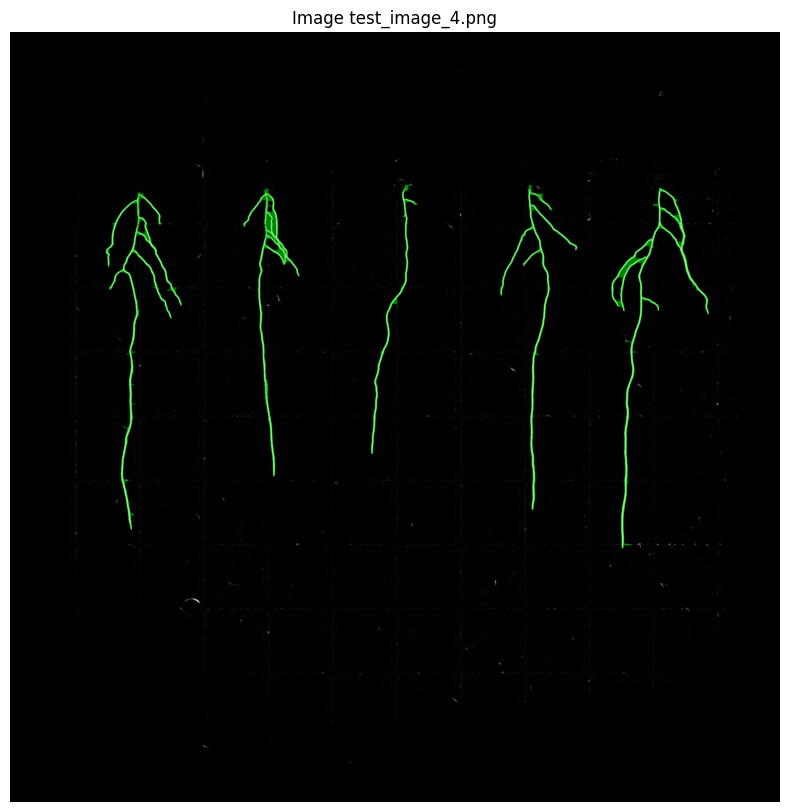

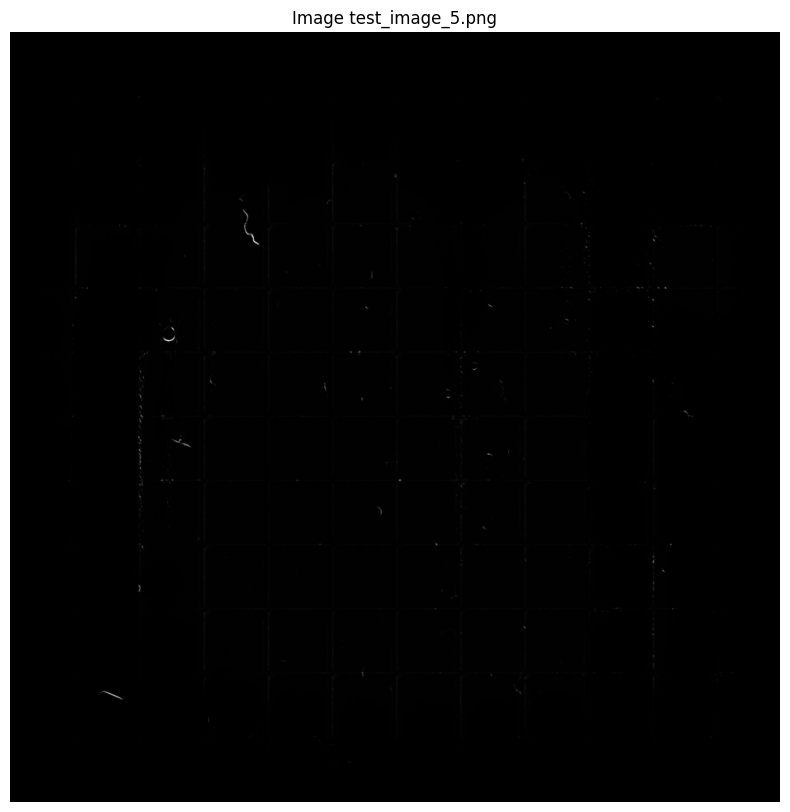

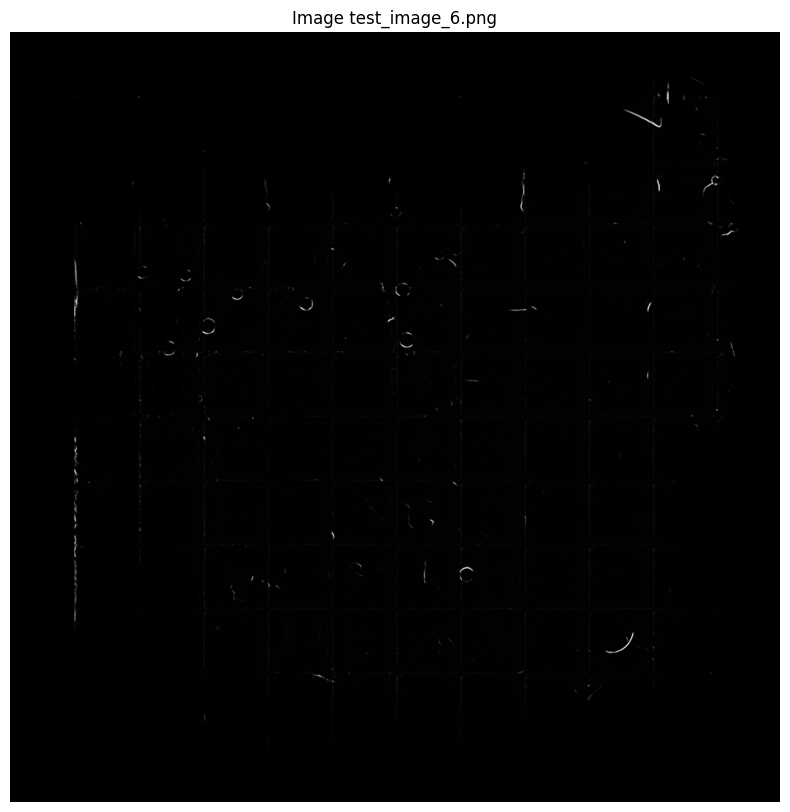

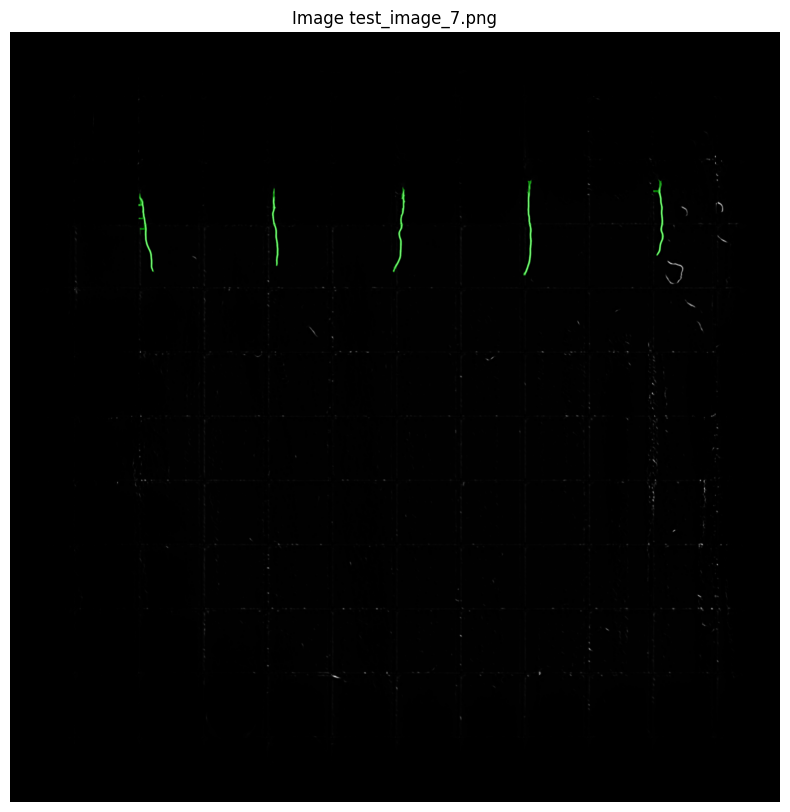

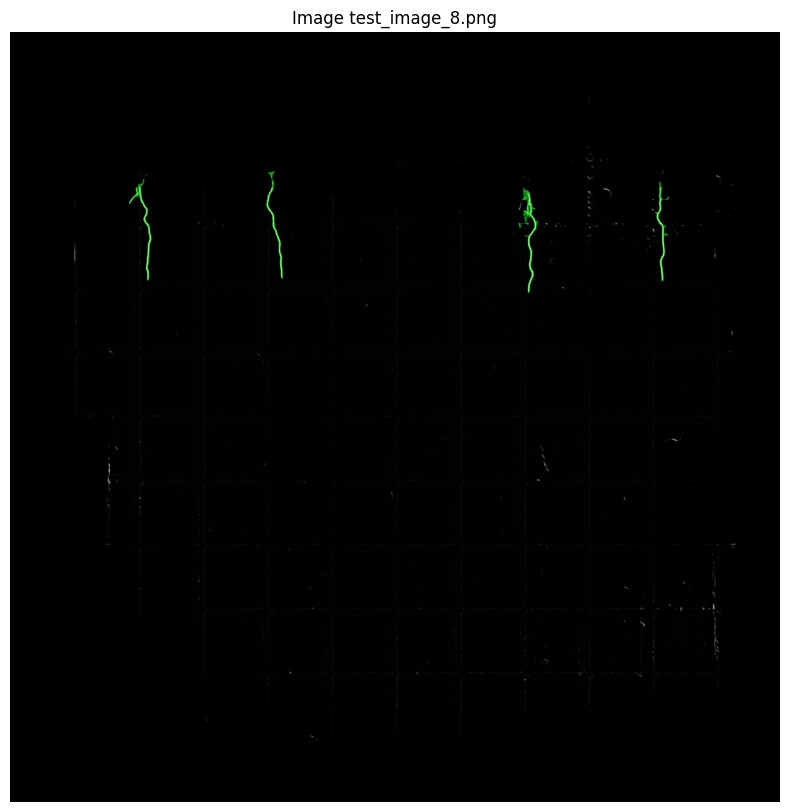

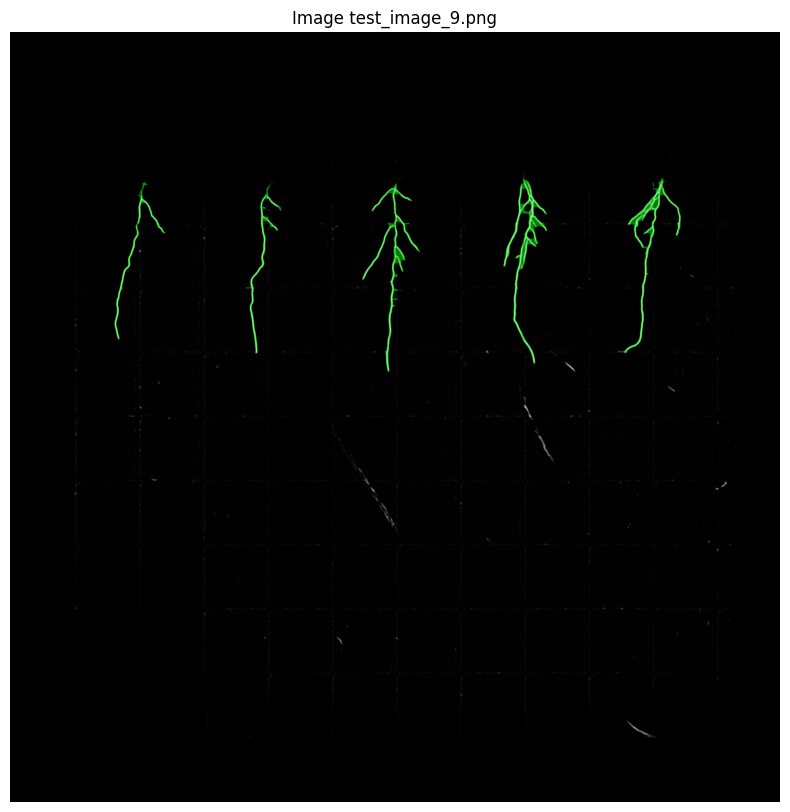

In [140]:
path = r'C:\Users\benjm\Downloads\Workspace\final\processed'
destination_path = r'C:\Users\benjm\Downloads\Workspace\final\task_5ed'

for filename in os.listdir(path):
    if filename.endswith('.png'):  # Change to '.jpg' or other file types if necessary
        image_path = os.path.join(path, filename)
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = process_mask(gray)
        overlay = img.copy()
        overlay[mask == 255] = (0, 255, 0)  # Green color for the overlay of the mask

        # Combine the image and the overlay
        alpha = 0.5  # Transparency factor.
        combined = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
        plt.title(f'Image {filename}')
        plt.axis('off')  # Hide the axis
        save_path = os.path.join(destination_path, filename)
        cv2.imwrite(save_path, mask)

plt.show()
